In [66]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pandas as pd
import torch
import umap


In [67]:
import sys
sys.path.append('/home/huan/Documents/MedDiff')
from models.vae import VariationalAutoencoder

In [68]:
tasks = [
    'mortality_48h',
    'ARF_4h', 
    'ARF_12h',
    'Shock_4h',
    'Shock_12h',
]
task = tasks[1]

s = np.load('../FIDDLE_eicu/features/{}/s.npz'.format(task))
X = np.load('../FIDDLE_eicu/features/{}/X.npz'.format(task))
s_feature_names = json.load(open('../FIDDLE_eicu/features/{}/s.feature_names.json'.format(task), 'r'))
X_feature_names = json.load(open('../FIDDLE_eicu/features/{}/X.feature_names.json'.format(task), 'r'))
df_pop = pd.read_csv('../FIDDLE_eicu/population/{}.csv'.format(task))
x_s = torch.sparse_coo_tensor(torch.tensor(s['coords']), torch.tensor(s['data'])).to_dense().to(torch.float32)
x_t = torch.sparse_coo_tensor(torch.tensor(X['coords']), torch.tensor(X['data'])).to_dense().to(torch.float32)
x_t = x_t.sum(dim=1).to(torch.float32)

In [70]:
y = df_pop.ARF_LABEL.values
indices = np.random.permutation(x_t.shape[0])
tt = int(x_t.shape[0]*0.8)
tt

111072

In [97]:

training_idx, test_idx = indices[:tt], indices[tt:]
t_training, t_test = x_t[training_idx,:], x_t[test_idx,:]
s_training, s_test = x_s[training_idx,:], x_s[test_idx,:]
y_training, y_test = y[training_idx], y[test_idx]

In [72]:

svae = VariationalAutoencoder(717).to('cuda')
tvae = VariationalAutoencoder(5854).to('cuda')
tvae = torch.load('../Synthetic_MIMIC/vae_tmp.pt')
svae = torch.load('../Synthetic_MIMIC/vae_stat.pt')

In [90]:
mu, logvar = tvae.encode(t_training.cuda())
zt = tvae.reparameterize(mu, logvar)

mu, logvar = svae.encode(s_training.cuda())
zs = tvae.reparameterize(mu, logvar)


In [75]:
zs.shape

torch.Size([111072, 128])

In [76]:
manifold = umap.UMAP().fit(t_training.detach().cpu().numpy(), y_training)

In [77]:
import umap.plot

<AxesSubplot:>

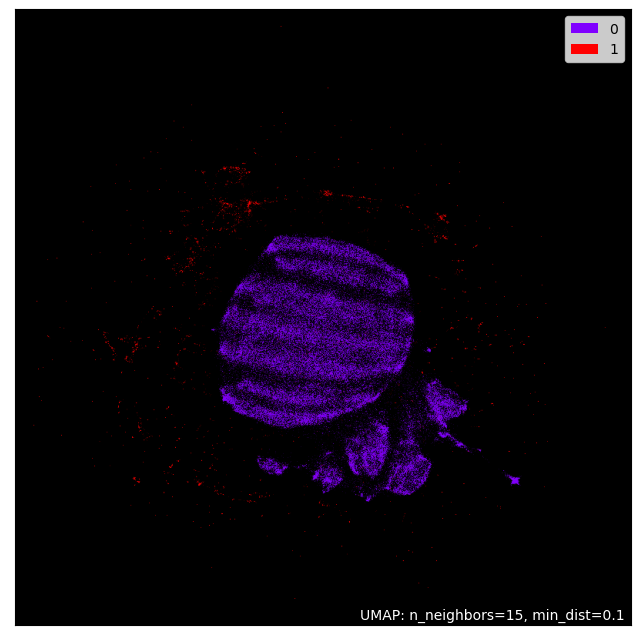

In [78]:
umap.plot.points(manifold, labels=y_training, theme="fire")

In [79]:
manifolds = umap.UMAP().fit(s_training.detach().cpu().numpy(), y_training)

<AxesSubplot:>

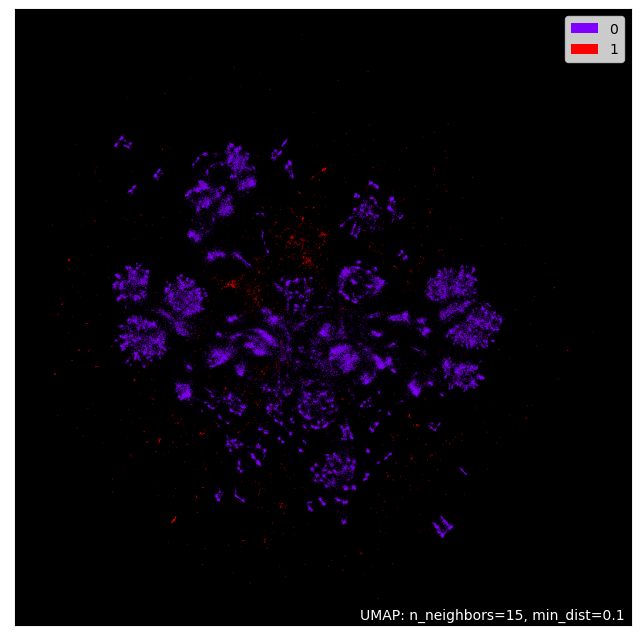

In [80]:
umap.plot.points(manifolds, labels=y_training, theme="fire")

In [81]:
import matplotlib.pyplot as pl
import numpy as np
import ot
from ot.gromov import gromov_wasserstein, fused_gromov_wasserstein

In [ ]:
# We create two 1D random measures
n = 20  # number of points in the first distribution
n2 = 30  # number of points in the second distribution
sig = 1  # std of first distribution
sig2 = 0.1  # std of second distribution

np.random.seed(0)



In [ ]:
xt.shape

In [ ]:
xt = manifold.embedding_[0:,0][:,None]
yt = manifold.embedding_[0::,1][:,None]
xs = manifolds.embedding_[0::,0][:,None]
ys = manifolds.embedding_[0::,1][:,None]

In [ ]:
C1 = ot.dist(xs)
C2 = ot.dist(xt)
M = ot.dist(ys, yt)
w1 = ot.unif(C1.shape[0])
w2 = ot.unif(C2.shape[0])
Got = ot.emd([], [], M)

In [ ]:
pl.figure(1, (7, 7))

pl.subplot(2, 1, 1)

pl.scatter(ys, xs, c=y_training[0:], s=70)
pl.ylabel('Feature value a', fontsize=20)
pl.title('$\mu=\sum_i \delta_{x_i,a_i}$', fontsize=25, y=1)
pl.xticks(())
pl.yticks(())
pl.subplot(2, 1, 2)
pl.scatter(yt, xt, c=y_training[0:], s=70)
pl.xlabel('coordinates x/y', fontsize=25)
pl.ylabel('Feature value b', fontsize=20)
pl.title('$\\nu=\sum_j \delta_{y_j,b_j}$', fontsize=25, y=1)
pl.yticks(())
pl.tight_layout()
pl.show()

In [ ]:
cmap = 'Reds'

pl.figure(2, (5, 5))
fs = 15
# l_x = [0, 5, 10, 15]
# l_y = [0, 5, 10, 15, 20, 25]
gs = pl.GridSpec(5, 5)

ax1 = pl.subplot(gs[3:, :2])

pl.imshow(C1, cmap=cmap, interpolation='nearest')
pl.title("$C_1$", fontsize=fs)
pl.xlabel("$k$", fontsize=fs)
pl.ylabel("$i$", fontsize=fs)
# pl.xticks(l_x)
# pl.yticks(l_x)

ax2 = pl.subplot(gs[:3, 2:])

pl.imshow(C2, cmap=cmap, interpolation='nearest')
pl.title("$C_2$", fontsize=fs)
pl.ylabel("$l$", fontsize=fs)
pl.xticks(())
# pl.yticks(l_y)
ax2.set_aspect('auto')

ax3 = pl.subplot(gs[3:, 2:], sharex=ax2, sharey=ax1)
pl.imshow(M, cmap=cmap, interpolation='nearest')
# pl.yticks(l_x)
# pl.xticks(l_y)
pl.ylabel("$i$", fontsize=fs)
pl.title("$M_{AB}$", fontsize=fs)
pl.xlabel("$j$", fontsize=fs)
pl.tight_layout()
ax3.set_aspect('auto')
pl.show()

In [ ]:
alpha = 1e-3
p = ot.unif(80)
q = ot.unif(80)
ot.tic()
Gwg, logw = fused_gromov_wasserstein(M, C1, C2, p, q, loss_fun='square_loss', alpha=alpha, verbose=True, log=True)
ot.toc()

# reload_ext WGW
Gg, log = gromov_wasserstein(C1, C2, p, q, loss_fun='square_loss', verbose=True, log=True)

In [ ]:
# visu OT matrix
cmap = 'Blues'
fs = 15
pl.figure(3, (13, 5))
pl.clf()
pl.subplot(1, 3, 1)
pl.imshow(Got, cmap=cmap, interpolation='nearest')
pl.ylabel("$i$", fontsize=fs)
pl.xticks(())

pl.title('Wasserstein ($M$ only)')

pl.subplot(1, 3, 2)
pl.imshow(Gg, cmap=cmap, interpolation='nearest')
pl.title('Gromov ($C_1,C_2$ only)')
pl.xticks(())
pl.subplot(1, 3, 3)
pl.imshow(Gwg, cmap=cmap, interpolation='nearest')
pl.title('FGW  ($M+C_1,C_2$)')

pl.xlabel("$j$", fontsize=fs)
pl.ylabel("$i$", fontsize=fs)

pl.tight_layout()
pl.show()

In [ ]:
Gwg

In [ ]:
Gwg.shape

In [ ]:
manifold.embedding_.shape

In [82]:
xs = manifold.embedding_
xt = manifolds.embedding_

In [114]:
mu, logvar = tvae.encode(t_training.cuda())
zt = tvae.reparameterize(mu, logvar)

mu, logvar = svae.encode(s_training.cuda())
zs = tvae.reparameterize(mu, logvar)


In [115]:
Ae, be = empirical_bures_wasserstein_mapping(zt.cpu().detach().numpy(), zs.cpu().detach().numpy())





In [116]:
mu, logvar = tvae.encode(t_test.cuda())
ztt = tvae.reparameterize(mu, logvar)

mu, logvar = svae.encode(s_test.cuda())
zst = tvae.reparameterize(mu, logvar)


In [119]:
zttr = ztt.detach().cpu().numpy().dot(Ae) + be

In [120]:
xtr = svae.decode(torch.cuda.FloatTensor(zttr))

In [121]:
s_test

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.]])

In [123]:
xtr[xtr<0.5]=0
xtr[xtr>=0.5] = 1

In [126]:
xtr.shape

torch.Size([27768, 717])

In [125]:
s_test

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.]])

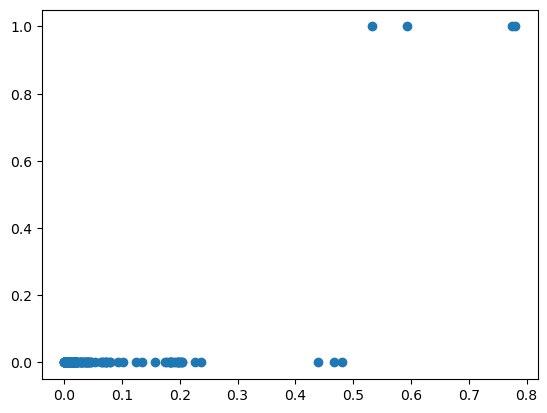

In [127]:
real_prob = np.mean(s_test.cpu().detach().numpy(), axis=0)
fake_prob = np.mean(xtr.cpu().detach().numpy(), axis=0)
plt.scatter(real_prob, fake_prob)

In [ ]:
ot.backend

In [ ]:
from ot.backend import get_backend
from ot.utils import dots
from ot.utils import list_to_array

def empirical_bures_wasserstein_mapping(xs, xt, reg=1e-6, ws=None,
                                        wt=None, bias=True, log=False):
    r"""Return OT linear operator between samples.

    The function estimates the optimal linear operator that aligns the two
    empirical distributions. This is equivalent to estimating the closed
    form mapping between two Gaussian distributions :math:`\mathcal{N}(\mu_s,\Sigma_s)`
    and :math:`\mathcal{N}(\mu_t,\Sigma_t)` as proposed in
    :ref:`[1] <references-OT-mapping-linear>` and discussed in remark 2.29 in
    :ref:`[2] <references-OT-mapping-linear>`.

    The linear operator from source to target :math:`M`

    .. math::
        M(\mathbf{x})= \mathbf{A} \mathbf{x} + \mathbf{b}

    where :

    .. math::
        \mathbf{A} &= \Sigma_s^{-1/2} \left(\Sigma_s^{1/2}\Sigma_t\Sigma_s^{1/2} \right)^{1/2}
        \Sigma_s^{-1/2}

        \mathbf{b} &= \mu_t - \mathbf{A} \mu_s

    Parameters
    ----------
    xs : array-like (ns,d)
        samples in the source domain
    xt : array-like (nt,d)
        samples in the target domain
    reg : float,optional
        regularization added to the diagonals of covariances (>0)
    ws : array-like (ns,1), optional
        weights for the source samples
    wt : array-like (ns,1), optional
        weights for the target samples
    bias: boolean, optional
        estimate bias :math:`\mathbf{b}` else :math:`\mathbf{b} = 0` (default:True)
    log : bool, optional
        record log if True


    Returns
    -------
    A : (d, d) array-like
        Linear operator
    b : (1, d) array-like
        bias
    log : dict
        log dictionary return only if log==True in parameters


    .. _references-OT-mapping-linear:
    References
    ----------
    .. [1] Knott, M. and Smith, C. S. "On the optimal mapping of
        distributions", Journal of Optimization Theory and Applications
        Vol 43, 1984

    .. [2] Peyré, G., & Cuturi, M. (2017). "Computational Optimal
        Transport", 2018.
    """
    xs, xt = list_to_array(xs, xt)
    nx = get_backend(xs, xt)

    d = xs.shape[1]

    if bias:
        mxs = nx.mean(xs, axis=0)[None, :]
        mxt = nx.mean(xt, axis=0)[None, :]

        xs = xs - mxs
        xt = xt - mxt
    else:
        mxs = nx.zeros((1, d), type_as=xs)
        mxt = nx.zeros((1, d), type_as=xs)

    if ws is None:
        ws = nx.ones((xs.shape[0], 1), type_as=xs) / xs.shape[0]

    if wt is None:
        wt = nx.ones((xt.shape[0], 1), type_as=xt) / xt.shape[0]

    Cs = nx.dot((xs * ws).T, xs) / nx.sum(ws) + reg * nx.eye(d, type_as=xs)
    Ct = nx.dot((xt * wt).T, xt) / nx.sum(wt) + reg * nx.eye(d, type_as=xt)

    if log:
        A, b, log = bures_wasserstein_mapping(mxs, mxt, Cs, Ct, log=log)
        log['Cs'] = Cs
        log['Ct'] = Ct
        return A, b, log
    else:
        A, b = bures_wasserstein_mapping(mxs, mxt, Cs, Ct)
        return A, b

Text(0.5, 1.0, 'Transported samples with Monge')

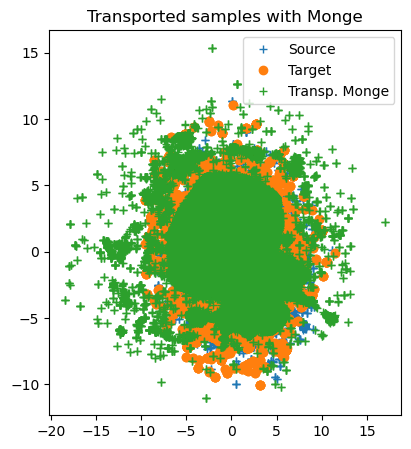

In [85]:
plt.figure(2, (10, 5))
plt.clf()
plt.subplot(1, 2, 1)
plt.plot(xs[:, 0], xs[:, 1], '+')
plt.plot(xt[:, 0], xt[:, 1], 'o')
plt.plot(xst[:, 0], xst[:, 1], '+')
plt.legend(('Source', 'Target', 'Transp. Monge'), loc=0)
plt.title('Transported samples with Monge')

In [ ]:
be.shape